In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import numpy as np
import glob
import logging
import os
import sys
import time

from caffe2.python import workspace

from detectron.core.config import assert_and_infer_cfg
from detectron.core.config import cfg
from detectron.core.config import merge_cfg_from_file
from detectron.utils.io import cache_url
from detectron.utils.logging import setup_logging
from detectron.utils.timer import Timer
import detectron.core.test_engine as infer_engine
import detectron.datasets.dummy_datasets as dummy_datasets
import detectron.utils.c2 as c2_utils
# import detectron.utils.vis as vis_utils

c2_utils.import_detectron_ops()

# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)

import easydict

Found Detectron ops lib: /usr/local/lib/python3.6/dist-packages/torch/lib/libcaffe2_detectron_ops_gpu.so


In [3]:
import os
from os.path import join
# cwd = os.getcwd()
# print('cwd:',cwd)
cwd='/Detectron'
print(cwd)
sys.path.insert(0,cwd)


/Detectron


In [5]:
wts='pre_weight/model_final.pkl'
args = easydict.EasyDict({
    "cfg": '/localDataset/cocodataset/2014/heidi_test/0_heidi_yaml/e2e_mask_and_keypoint_rcnn_R-50-FPN_1x.yaml',
    "weights": join(localDatasets,wts),
    "output_dir": '/localDataset/cocodataset/2014/heidi_test/detectron_test',
    "image_ext": 'jpg',
    "out_when_no_box": 'store_true',
    "output_ext": 'png', 
    "thresh": 0.85,
    "kp_thresh": 2.0,
    "im_or_folder": '/localDataset/data/2014/heidi_test/demo',
 
})



NameError: name 'localDatasets' is not defined

In [4]:
merge_cfg_from_file(args.cfg)

In [5]:

cfg.NUM_GPUS = 1
args.weights = cache_url(args.weights, cfg.DOWNLOAD_CACHE)
assert_and_infer_cfg(cache_urls=False)

detectron_model = infer_engine.initialize_model_from_cfg(args.weights)
dummy_coco_dataset = dummy_datasets.get_coco_dataset()

INFO:detectron.utils.net:Loading weights from: /Detectron/pre_weight/model_final.pkl
INFO:detectron.utils.net:conv1_w loaded from weights file into gpu_0/conv1_w: (64, 3, 7, 7)
INFO:detectron.utils.net:res_conv1_bn_s loaded from weights file into gpu_0/res_conv1_bn_s: (64,)
INFO:detectron.utils.net:res_conv1_bn_b loaded from weights file into gpu_0/res_conv1_bn_b: (64,)
INFO:detectron.utils.net:res2_0_branch2a_w loaded from weights file into gpu_0/res2_0_branch2a_w: (64, 64, 1, 1)
INFO:detectron.utils.net:res2_0_branch2a_bn_s loaded from weights file into gpu_0/res2_0_branch2a_bn_s: (64,)
INFO:detectron.utils.net:res2_0_branch2a_bn_b loaded from weights file into gpu_0/res2_0_branch2a_bn_b: (64,)
INFO:detectron.utils.net:res2_0_branch2b_w loaded from weights file into gpu_0/res2_0_branch2b_w: (64, 64, 3, 3)
INFO:detectron.utils.net:res2_0_branch2b_bn_s loaded from weights file into gpu_0/res2_0_branch2b_bn_s: (64,)
INFO:detectron.utils.net:res2_0_branch2b_bn_b loaded from weights file 

In [6]:
if os.path.isdir(args.im_or_folder):
    print('folder')
    #im_list = glob.iglob(args.im_or_folder + '/*.' + args.image_ext)
    im_list = glob.glob(args.im_or_folder + '/*.' + args.image_ext)
else:
    print('img list')
    im_list = [args.im_or_folder]
    
print('im_list:',im_list)

folder
im_list: ['/datasets/data/2014/heidi_test/demo/p02.jpg', '/datasets/data/2014/heidi_test/demo/p01.jpg', '/datasets/data/2014/heidi_test/demo/p03.jpg']


In [58]:
%matplotlib inline  

def get_body_part(ori_img, mask, kps,bbox=(0,0,100,200), kp_thresh=2):
    
    x1,y1,x2,y2 = bbox
    
    #print('mask')
    #plt.imshow(mask)
    #plt.show()
    
    mask_img = ori_img.copy()
    mask_img[mask==0]=mask[mask==0]
    
    p_img = mask_img[y1:y2,x1:x2,:]
    
    #print('p_img')
    #plt.imshow(p_img)
    #plt.show()
    
    cut_list = [[0,1,2,3,4],[5,6],[11,12],[13,14],[15,16]] 

    p_head =False
    p_shoulder = False
    p_pelvis =False
    p_knee = False
    p_foot = False
    
    is_person =False
    
    is_front= True
    
    if int(kps[0, 5]) < int(kps[0, 6]):
        is_front= False
    #return p_img.astype(np.uint8), False
    for k in range(17):    
        if kps[2, k] > kp_thresh:
            p1=int(kps[0, k]-x1),int(kps[1, k]-y1)
            #cv2.circle(p_img, p1,radius=3, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
            #print('k',k)
            if k in cut_list[0] and p_head==False: 
                p_head= True
                
            if k in cut_list[1] and p_shoulder==False: 
                p_shoulder= True
                
            if k in cut_list[2] and p_pelvis==False: 
                p_pelvis= True
                
            if k in cut_list[3] and p_knee==False: 
                p_knee= True     
                
            if k in cut_list[4] and p_foot==False: 
                p_foot= True

    ph, pw, pch  = p_img.shape
    
    if p_head and p_foot:
        #print('head foot')
        whole_body_img = p_img
        is_person=True
        
    elif p_head and p_knee:
        #print('head knee')
        half_leg_len = int(abs(kps[1, 14] - kps[1, 12] ))
        
        zerobox=np.zeros((ph+half_leg_len,pw,3))
        zerobox[0:ph,:,:]=p_img[:,:,:]
        
        whole_body_img=zerobox
        is_person=True
    
    elif p_head and p_pelvis:
        #print('head pelvis')
        half_body_len = int(abs(kps[1, 12] - kps[1, 0] ))
        
        zerobox=np.zeros((ph+half_body_len,pw,3))
        zerobox[0:ph,:,:]=p_img[:,:,:]
        
        whole_body_img=zerobox
        is_person=True
    
    elif p_head and p_shoulder:
        #print('head p_shoulder')
        #half_body_len = int(abs(kps[1, 5] - kps[1, 0] ))
        
        zerobox=np.zeros((int(ph*2.2),pw,3))
        zerobox[0:ph,:,:]=p_img[:,:,:]
        
        whole_body_img=zerobox
        is_person=True
        
    else:
        #print('no person')
        whole_body_img=p_img
        
    return whole_body_img.astype(np.uint8), is_person, is_front

In [59]:

import cv2
import numpy as np
import os

import pycocotools.mask as mask_util

from detectron.utils.colormap import colormap
import detectron.utils.env as envu
import detectron.utils.keypoints as keypoint_utils

# Matplotlib requires certain adjustments in some environments
# Must happen before importing matplotlib
envu.set_up_matplotlib()
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

plt.rcParams['pdf.fonttype'] = 42  # For editing in Adobe Illustrator

def convert_from_cls_format(cls_boxes, cls_segms, cls_keyps):
    """Convert from the class boxes/segms/keyps format generated by the testing
    code.
    """
    box_list = [b for b in cls_boxes if len(b) > 0]
    if len(box_list) > 0:
        boxes = np.concatenate(box_list)
    else:
        boxes = None
    if cls_segms is not None:
        segms = [s for slist in cls_segms for s in slist]
    else:
        segms = None
    if cls_keyps is not None:
        keyps = [k for klist in cls_keyps for k in klist]
    else:
        keyps = None
    classes = []
    for j in range(len(cls_boxes)):
        classes += [j] * len(cls_boxes[j])
    return boxes, segms, keyps, classes

def vis_mask_v2(img, mask):
    """Visualizes a single binary mask."""

    zero_img = np.zeros_like(img).astype(np.float32)
    #img = img.astype(np.float32)
    idx = np.nonzero(mask)

    zero_img[idx[0], idx[1], :] *= 0 #1.0 - alpha
    zero_img[idx[0], idx[1], :] += (255,255,255)#alpha * col

    return zero_img.astype(np.uint8)


def vis_one_image_opencv_heidi(
    im, boxes, segms=None, keypoints=None, thresh=0.90, kp_thresh=2,
    show_box=False, dataset=None, show_class=False):
    """Constructs a numpy array with the detections visualized."""
    my_mask = np.zeros_like(im) 
    person_mask = np.zeros_like(im) 
    
    ori_img=im.copy()
    
    bbox_list=[]
    pbox_list=[]
    if isinstance(boxes, list):
        boxes, segms, keypoints, classes = convert_from_cls_format(
            boxes, segms, keypoints)

    if boxes is None or boxes.shape[0] == 0 or max(boxes[:, 4]) < thresh:
        return my_mask, bbox_list, pbox_list

    if segms is not None and len(segms) > 0:
        
        #print('segms:',len(segms))
        masks = mask_util.decode(segms)
        color_list = colormap()
        mask_color_id = 0

    # Display in largest to smallest order to reduce occlusion
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    sorted_inds = np.argsort(-areas)

    for i in sorted_inds:
        bbox = boxes[i, :4]
        score = boxes[i, -1]
        #print('score:',score,thresh)
        if score < thresh:
            continue
            
        x1,y1,x2,y2= (int(bbox[0]), int(bbox[1]), int(bbox[2]) ,int( bbox[3]))
        bbox = x1,y1,x2,y2
        #print('x1,y1,x2,y2:',x1,y1,x2,y2)
        
        bbox_list.append((x1,y1,x2,y2))

        #print('score:',score)
        # show mask
        if segms is not None and len(segms) > i:
            zero_img = vis_mask_v2(ori_img, masks[..., i])
            my_mask[zero_img==255]=255#ori_img[zero_img==255]
            
            person_mask[:,:,:]=0
            person_mask[zero_img==255]=255
            
        # show keypoints
        if keypoints is not None and len(keypoints) > i:
            kps=keypoints[i]
            zerobox, zero_bool,zero_front = get_body_part(ori_img, person_mask, kps,bbox)
            
            pbox_list.append([zerobox, zero_bool,zero_front])
            """
            
            for l in range(17):       
                if kps[2, l] > kp_thresh:
                    p3 = int(kps[0, l]), int(kps[1, l])
                    
                    cv2.putText(ori_img, str(l), (p3), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            """

    return my_mask, bbox_list, pbox_list


---

In [8]:
# import os
# cwd = os.getcwd()

# from os.path import join
# import numpy as np
# import cv2
# import sys
# import glob
# import time
# from PIL import Image
# import matplotlib.pyplot as plt

---
## REID

In [9]:
import cv2
import numpy as np
import os

h,w,ch = 200, 200, 3

def __get_heidinet_path_feature__(img_path):
    print(os.path.isfile(img_path))
    one_img = cv2.imread(img_path)
    re_one_img = (cv2.resize(one_img,(h,w))/255.).reshape(-1,h,w,ch)
    return re_one_img-1
    #return new_model.predict(re_one_img)
    
def __get_heidinet_cv_feature__(one_img):
    #re_one_img = (cv2.resize(one_img,(h,w))/255.).reshape(-1*h*w*ch) 
    re_one_img = (cv2.resize(one_img,(h,w))/255.).reshape(-1,h,w,ch)
    return re_one_img-1

In [10]:

def __near_box_area__(h,w,bbox,m1=10,m2=10):
    #m = (w//7)#*2
    cx1,cy1,cx2,cy2 = bbox#10,10,100,200  # current position
    
    rx1 = cx1-m1 if (cx1-m1)>0 else 0
    ry1 = cy1-m2 if (cy1-m2)>0 else 0
    
    rx2 = cx2+m1 if (cx2+m1)<(w-1) else w-1
    ry2 = cy2+m2 if (cy2+m2)<(h-1) else h-1
    
    return [rx1,ry1,rx2,ry2]

def __near_box_area_walk__(h,w,bbox, pbbox):
    #m = (w//7)#*2
    cx1,cy1,cx2,cy2 = bbox#10,10,100,200  # current position
    
    bw= (cx2-cx1)#//2 #person width
    bh = (cy2-cy1)#//2 #person tall
    
    
    cx = cx1 + (bw//2)
    cy = cy1 + (bh//2)
    
    px1,py1,px2,py2 = pbbox
    
    px = px1 + (px2-px1)//2
    py = py1 + (py2-py1)//2
    
    dx = int((cx-px)*1.2)
    dy = int((cy-py)*1.2)
    
    
    if dx < bw*0.5 :
        m1 = int(bw*0.7)#1.0)
    else:
        m1 = int(dx *0.7)#0.7)
        
    if dy <bh*0.5:
        m2 = -int(bh*0.2)
    else:
        m2 = -int(dy * 0.2)

    
    if dx>=0:
        cx2=cx2+dx #if (cx2+dx)<(w-1) else w-1
    else:
        cx1=cx1+dx #if (cx1+dx)>0 else 0

    if dy>=0:
        cy2=cy2+dy #if (cy2+dy)<(h-1) else h-1
    else:
        cy1=cy1+dy #if (cy1+dy)>0 else 0
    
    rx1 = cx1-m1 if (cx1-m1)>0 else 0
    ry1 = cy1-m2 if (cy1-m2)>0 else 0
    
    rx2 = cx2+m1 if (cx2+m1)<(w-1) else w-1
    ry2 = cy2+m2 if (cy2+m2)<(h-1) else h-1
    
    return [rx1,ry1,rx2,ry2]



def __check_var_in_box__(abox, bbox):
    cx = (bbox[0]+bbox[2])//2
    cy = (bbox[1]+bbox[3])//2
    
    is_in_box = False
    if cx >abox[0] and cx<abox[2] and cy >abox[1] and cy<abox[3]:
        is_in_box = True
            
    return is_in_box


def __matching_id__(detect_list,id_list):
    all_cp=[]
    for i in detect_list:
        cpx = []
        for j in  id_list:
            cos_dist = spatial.distance.cosine(i[4],  j[1])
            cpx.append(cos_dist)
        all_cp.append(cpx)

    all_cp= np.array(all_cp)
    #print(all_cp)
    return all_cp


In [11]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
import os
current_dir = os.getcwd()

In [13]:

        
def __hist_e__(img):
    hist, bins = np.histogram(img.flatten(), 256,[0,256])

    cdf = hist.cumsum()

    # cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
    # mask처리가 되면 Numpy 계산에서 제외가 됨
    # 아래는 cdf array에서 값이 0인 부분을 mask처리함
    cdf_m = np.ma.masked_equal(cdf,0)

    #History Equalization 공식
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

    # Mask처리를 했던 부분을 다시 0으로 변환
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    img2 = cdf[img]
    return img2

def __get_resize_cv_data__(cv_img_, w=10, h =20, ch=3):
    #t1=cv2.imread(img_path)
    #cv_img2 = __hist_e__(cv_img)
    #cv_img2=cv_img
    cv_img2 = cv_img_.copy()
    cv_img2 = cv2.medianBlur(cv_img2,7)
    
    t1 = cv2.cvtColor(cv_img2, cv2.COLOR_BGR2RGB)#/255.
    t1 = cv2.resize(t1,(w,h), interpolation=cv2.INTER_CUBIC)/255.
#     plt.imshow(t1)
#     plt.show()
    t1[:,:,0] = ( t1[:,:,0] - 0.485)/0.229
    t1[:,:,1] = ( t1[:,:,1] - 0.456)/0.224
    t1[:,:,2] =  (t1[:,:,2] - 0.406)/0.225
    
    t1=t1.reshape((w*h*ch))
    return t1

In [14]:
import cv2
import numpy as np
from scipy import spatial

In [101]:

def __near_box_area_walk_v2__(h,w,bbox, pbbox,is_mode=False):
    #m = (w//7)#*2
    cx1,cy1,cx2,cy2 = bbox#10,10,100,200  # current position
    
    bw= (cx2-cx1)#//2 #person width
    bh = (cy2-cy1)#//2 #person tall
    
    cx = cx1 + (bw//2)
    cy = cy1 + (bh//2)
    
    m1 = int(bw*0.45)#1.0)
    m2 = -int(bh*0.3)
    
    rx1 = cx1-m1 if (cx1-m1)>0 else 0
    ry1 = cy1-m2 if (cy1-m2)>0 else 0
    
    rx2 = cx2+m1 if (cx2+m1)<(w-1) else w-1
    ry2 = cy2+m2 if (cy2+m2)<(h-1) else h-1
    
    return [rx1,ry1,rx2,ry2]

def __get_heiditest_path_data__(img_path_, w=200, h =200, ch=3):
    cv_img2=cv2.imread(img_path_)
    cv_img2 = cv2.medianBlur(cv_img2,7)
    
    t1 = cv2.cvtColor(cv_img2, cv2.COLOR_BGR2RGB)#/255.
    t1 = cv2.resize(t1,(w,h), interpolation=cv2.INTER_CUBIC)/255.
    
    t1[:,:,0] = ( t1[:,:,0] - 0.485)#/0.229
    t1[:,:,1] = ( t1[:,:,1] - 0.456)#/0.224
    t1[:,:,2] =  (t1[:,:,2] - 0.406)#/0.225
    
    t1=t1.reshape((-1,w,h,ch))
    return t1

def __get_heiditest_cv_data__(cv_img_, w=200, h =200, ch=3):
    #t1=cv2.imread(img_path)
    #cv_img2 = __hist_e__(cv_img)
    #cv_img2=cv_img
    cv_img2 = cv_img_.copy()
    #cv_img2 = cv2.medianBlur(cv_img2,7)
    
    t1 = cv2.cvtColor(cv_img2, cv2.COLOR_BGR2RGB)#/255.
    t1 = cv2.resize(t1,(w,h), interpolation=cv2.INTER_CUBIC)/255.
#     plt.imshow(t1)
#     plt.show()
    t1[:,:,0] = ( t1[:,:,0] - 0.485)#/0.229
    t1[:,:,1] = ( t1[:,:,1] - 0.456)#/0.224
    t1[:,:,2] =  (t1[:,:,2] - 0.406)#/0.225
    
    t1=t1.reshape((-1,w,h,ch))
    return t1

In [16]:
tzeroimg = np.zeros((200,200,3),dtype='uint8')
print(tzeroimg.shape)

a =[55,15,75,85]  
b = [65,25,85,75]  #[30,30,60,60]

cv2.rectangle(tzeroimg, (a[0],a[1]),(a[2],a[3]), (0, 125, 125), 1)
cv2.rectangle(tzeroimg, (b[0],b[1]),(b[2],b[3]), (125, 0, 125), 1)

x1,y1,x2,y2 = __near_box_area_walk_v2__(200,200,a,b)
print(x1,y1,x2,y2)
cv2.rectangle(tzeroimg, (x1,y1),(x2,y2), (255, 125, 125), 1)

plt.imshow(tzeroimg)
plt.show()

(200, 200, 3)
46 36 84 64


---

In [17]:
import sys
import cv2
import numpy as np
import time

def __camera_area_check__(x1,x2,y1,y2):
    return 0

def __create_dir__(dir_path):
    if not os.path.exists(dir_path):
        print('create: ', dir_path)
        os.makedirs(dir_path)

In [18]:
import linecache
import sys

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print ('\nEXCEPTION IN ({}, \nLINE {} \n{}\n{}'.format(filename, lineno, line.strip(), exc_obj))


i 0 /datasets/data/2014/heidi_test/demo/p01.jpg
pbox_list: 1
[(348, 34, 661, 964)]
pi 0 True


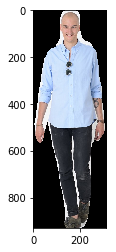

i 1 /datasets/data/2014/heidi_test/demo/p02.jpg
pbox_list: 2
[(132, 651, 549, 2039), (944, 566, 1305, 2099)]
pi 0 True


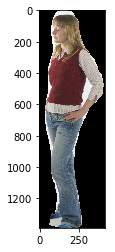

pi 1 True


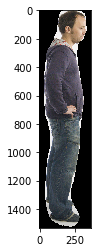

i 2 /datasets/data/2014/heidi_test/demo/p03.jpg
pbox_list: 1
[(0, 23, 237, 355)]
pi 0 True


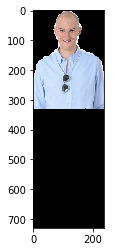

done


In [20]:
%matplotlib inline  

im_list.sort()
for i, im_name in enumerate(im_list):
    print('i',i,im_name)
    out_name = os.path.join(
        args.output_dir, '{}'.format(os.path.basename(im_name) + '.' + args.output_ext)
    )
    im = cv2.imread(im_name)
    timers = defaultdict(Timer)
    t = time.time()
    with c2_utils.NamedCudaScope(0):
        cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(
            detectron_model, im, None, timers=None
        )
        
    my_mask, bbox_list, pbox_list =vis_one_image_opencv_heidi(
        im[:, :, ::-1],  # BGR -> RGB for visualization
        cls_boxes,
        cls_segms,
        cls_keyps,
        thresh=args.thresh,
        kp_thresh=args.kp_thresh,
        show_box=True)
    

    print('pbox_list:',len(pbox_list))
    print(bbox_list)
    for pi,p in enumerate(pbox_list):
        print('pi',pi,p[1])
        if p[1]==True:
            plt.imshow(p[0])
            plt.show()
#             bbox=bbox_list[pi]
#             x1,y1,x2,y2=bbox
            
#             plt.imshow(ori_img[y1:y2,x1:x2,:])
#             plt.show()
print('done')

In [21]:
import sys
sys.path.append('/Detectron/heidi_net')

from heidinet import *

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

config.gpu_options.per_process_gpu_memory_fraction: 0.5


W0813 02:37:27.491629 140390865356544 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0813 02:37:27.542978 140390865356544 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0813 02:37:31.218806 140390865356544 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0813 02:37:44.978553 140390865356544 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: Th

Loaded model from disk


/Detectron/heidi_net/heidinet.py:272: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  heidi_resnet_model = Model(input = loaded_model.input[0], output = loaded_model.get_layer('resnet_model').get_output_at(-3))


In [22]:
import glob
import cv2
import numpy as np
import os
from os.path import join

In [29]:
from os import listdir
from os.path import isfile, join


In [63]:
id_path = '/datasets/data/2014/heidi_test/id_data'

id_list = [f for f in listdir(id_path) if isfile(join(id_path, f))]
id_list.sort()
print(id_list)

['p01_00.png', 'p01_01.png', 'p02_00.png', 'p02_01.png', 'p03_00.png', 'p03_01.png', 'p04_00.png', 'p04_01.png', 'p05_00.png', 'p05_01.png', 'p06_00.png', 'p06_01.png', 'p07_00.png', 'p07_01.png']


In [35]:
# id_feature_list = []
# for id_name in id_list:
#     id_cv_img = cv2.imread(join(id_path,id_name))
#     pre_id_img = __get_heiditest_cv_data__(id_cv_img)
#     id_feature = heidi_resnet_model.predict(pre_id_img)
#     id_feature_list.append([str(id_name),id_feature])
    
# print('id_feature_list')

id_feature_list


In [64]:
def convert_int2string_for_name(id_idx):
    if id_idx<10:
        id_idx = '0'+str(id_idx)
    else:
        id_idx = str(id_idx)
    return id_idx

In [69]:
id_path = '/datasets/data/2014/heidi_test/id_data'

id_feature_list = []
for id_idx in range(1,8):

    id_idx = convert_int2string_for_name(id_idx)
    person_id_name = id_idx
    
    person_fs=[]
    person_fs.append(person_id_name)
    for fb in range(2):
        fb = convert_int2string_for_name(fb)
        id_fb_name = "p{}_{}.png".format(id_idx,fb)
        print(join(id_path,id_fb_name))
        id_cv_img = cv2.imread(join(id_path,id_fb_name))
        pre_id_img = __get_heiditest_cv_data__(id_cv_img)
        id_feature = heidi_resnet_model.predict(pre_id_img)
        person_fs.append(id_feature)
        
    id_feature_list.append(person_fs)
    
print('id_feature_list')

/datasets/data/2014/heidi_test/id_data/p01_00.png
/datasets/data/2014/heidi_test/id_data/p01_01.png
/datasets/data/2014/heidi_test/id_data/p02_00.png
/datasets/data/2014/heidi_test/id_data/p02_01.png
/datasets/data/2014/heidi_test/id_data/p03_00.png
/datasets/data/2014/heidi_test/id_data/p03_01.png
/datasets/data/2014/heidi_test/id_data/p04_00.png
/datasets/data/2014/heidi_test/id_data/p04_01.png
/datasets/data/2014/heidi_test/id_data/p05_00.png
/datasets/data/2014/heidi_test/id_data/p05_01.png
/datasets/data/2014/heidi_test/id_data/p06_00.png
/datasets/data/2014/heidi_test/id_data/p06_01.png
/datasets/data/2014/heidi_test/id_data/p07_00.png
/datasets/data/2014/heidi_test/id_data/p07_01.png
id_feature_list


In [60]:


def tracking_heidinet(ori_img, alll_cam_n, tracking_infos, new_person_idx,
                      font_size=1,
                      miss_frame_num=3,
                      mr_output_path=None,
                      class_names=None,
                      id_feature_list=id_feature_list):
    
    #img = cv2.resize(img,dsize=(0, 0),fx=0.5,fy=0.5)

    with c2_utils.NamedCudaScope(0):
        cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(
            detectron_model, ori_img, None, timers=None
        )

    my_mask, bbox_list, pbox_list  =vis_one_image_opencv_heidi(
        ori_img, 
        cls_boxes, 
        segms=cls_segms, 
        keypoints=cls_keyps, 
        thresh=0.85, 
        kp_thresh=2,
        show_box=True)
    
    """
    for pi,p in enumerate(pbox_list):
        #print('pi',pi,p[1])
        if p[1]==True:
            plt.imshow(p[0])
            plt.show()
            #bbox=bbox_list[pi]
            #x1,y1,x2,y2=bbox
    """

    
    
    save_mask_img = ori_img.copy() 
    img=ori_img.copy()
    
    del ori_img
    
    N= len(pbox_list)
    print('N:',N)
    if N==0:
        pass
    else:
        new_person_list =[[] for _ in range(alll_cam_n)]
        current_infos = [[] for _ in range(alll_cam_n)]

        pc_dist_list = []
        cidx=0
        
        draw_info_bool =True
        for i in range(N):
            """
            ## bbox = [x, y, x, y, feature, my id, matching id, cos dist]
            ## bbox = [0,1,2,3 , 4         , 5        , 6               ,7           ]  
            """
            # axis
            x1,y1,x2,y2 = bbox_list[i]#y1, x1, y2, x2 = boxes[i]


            #class_id = class_ids[i]
            #score = scores[i] if scores is not None else None
            #label = class_names[class_id]

            if True:#label=='person':   
                
                pbox_img = save_mask_img[y1:y2,x1:x2,:]#.copy()
                cam_n = __camera_area_check__(x1,x2,y1,y2)

                ## get background mask
                #pbox_img_bk = pbox_img.copy()
                #pbox_img_bk[my_mask[y1:y2,x1:x2,i]==False]=0 ## remove background color
                
                pbox_img_bk = pbox_list[i][0]
                

                is_person= pbox_list[i][1]
                
                is_front = pbox_list[i][2]
                
                if idx>68 and idx <80:
                    print('idx',idx,is_person)
                    plt.imshow(pbox_img_bk)
                    plt.show()
                
                if is_person is False:
                    continue
                    
                if mr_output_path:
                    #cv2.imwrite(join(mr_output_path,str(idx)+'_'+str(i)+'.jpg'), pbox_img)
                    cv2.imwrite(join(mr_output_path,str(idx)+'_'+str(i)+'_2_'+'.jpg'), pbox_img_bk)
                    
                    
                ## get current_feature  
                pre_img_bk = __get_heiditest_cv_data__(pbox_img_bk)
                current_feature = heidi_resnet_model.predict(pre_img_bk)

                ## current info list update
                current_info = [x1,y1,x2,y2, current_feature, cidx, False, is_front]
                current_infos[cam_n].append([0, current_info])
                
                
                ## current bbox 중심 그리기
                tcx = (x1+x2)//2
                tcy = (y1+y2)//2
                cv2.circle(img, (tcx,tcy),3, (0, 0, 255), -1)

                #print('cidx:',cidx)
                if len(tracking_infos[cam_n])>0:
                    for tidx, tracking_info in enumerate(tracking_infos[cam_n]):
                        #print('tidx;',tidx)
                        pre_person_idx = tracking_info[-1][5]
                        pre_bbox = tracking_info[-1][:4]
                        pre_feature = tracking_info[-1][4]

                        near_tracking_bbox = __near_box_area_walk_v2__(fh, fw, pre_bbox, pre_bbox)


                        ##근처 영역 그리기
                        #print('near_tracking_bbox:',near_tracking_bbox)
                        if draw_info_bool:
                            #px1,py1,px2,py2 = pre_bbox
                            #cv2.rectangle(img, (px1,py1),(px2,py2), (255, 255, 0), 1)
                            #cv2.putText(img, str(tidx),(px1,py1+20) ,cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255, 0), 1)
                            
                            nx1,ny1,nx2,ny2 = near_tracking_bbox
                            cv2.rectangle(img, (nx1,ny1),(nx2,ny2), (125, 125, 0), 1)
                            

                        #print('get_iou:',get_iou(near_tracking_bbox, [x1,y1,x2,y2]))
                        if get_iou(near_tracking_bbox, [x1,y1,x2,y2]) > 0.05:
                            #print('pc_dist_list update')
                            pc_dist = np.linalg.norm(pre_feature - current_feature)
                            print('idx %d, tidx %d, cidx: %d, pc_dist: %f'%(idx, tidx, cidx, pc_dist))
                            #print('pc_dist:',cidx, tidx, pc_dist)
                            pc_dist_list.append([cam_n, tidx, cidx, pc_dist, current_info, pre_person_idx])
                            #cv2.putText(img, 'box in',(nx1,ny1+20) ,cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0, 125), 1)
                            
                draw_info_bool=False
                cv2.rectangle(img, (x1,y1),(x2,y2), (255, 125, 125), 1)
                cv2.putText(img, str(cidx)+'_current',(x1,y1+20) ,cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,125, 255), 1)
                cv2.putText(img, str(is_front),(x1,y1+40) ,cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,125, 255), 1)
                cidx+=1

        # here tap start
        ##if len(pc_dist_list)>0:
        if len(pc_dist_list)>0:
            sorted_pc_dist_list = sorted(pc_dist_list, key=lambda x: x[3])
            tracking_len = len(tracking_infos[0])

            # tracking_len tap start

            current_true_list = []
            for tidx in range(tracking_len):
                if len(sorted_pc_dist_list)<1:
                    #print('break')
                    break

                """
                sorted_pc_dist_list[0][cam_n, pidx, cidx, pc_dist, current_info]
                """
                pc_short_cam_n = sorted_pc_dist_list[0][0] 
                pc_short_p_idx = sorted_pc_dist_list[0][1] 
                pc_short_c_idx = sorted_pc_dist_list[0][2] 
                pc_short_dist = sorted_pc_dist_list[0][3] 
                pc_short_info = sorted_pc_dist_list[0][4] 
                person_idx = sorted_pc_dist_list[0][5] 
                person_fb = sorted_pc_dist_list[0][7] 

                #print('pc_short:%s ,pc_cur_short:%s , pc_short_dist: %f' %(pc_short_p_idx, pc_short_c_idx, pc_short_dist))

                #print(tracking_infos[pc_short_cam_n][pc_short_p_idx][-1])
                #person_idx  = tracking_infos[pc_short_cam_n][pc_short_p_idx][-1][5]


                """
                tracking_infos[cam_number][tracking_index][old~recent][x1,y1,x2,y2,feature,id,false]
                """

                ## update
                pc_short_info[5] = person_idx
                tracking_infos[pc_short_cam_n][pc_short_p_idx].append(pc_short_info)
                #tracking_infos[pc_short_cam_n][pc_short_p_idx][0]=0 ##진행한 프레임수

                if len(tracking_infos[pc_short_cam_n][pc_short_p_idx])>=3:#miss_frame_num:
                    tracking_infos[pc_short_cam_n][pc_short_p_idx].pop(1)
                    tracking_infos[pc_short_cam_n][pc_short_p_idx][0]=0 ##초기화

                #current_true_list.append(pc_short_c_idx)
                current_infos[pc_short_cam_n][pc_short_c_idx][-1][6] = True
                current_infos[pc_short_cam_n][pc_short_c_idx][-1][5] = person_idx


                # 남아있는 할당된 현재 프레임 제거
                sorted_pc_dist_list=[x for x in (sorted_pc_dist_list) if x[2]!=pc_short_c_idx]

                # 남아있는 할당된 이전 프레임 제거
                sorted_pc_dist_list=[x for x in (sorted_pc_dist_list) if x[1]!=pc_short_p_idx]
                #print('person_idx:',person_idx)


        # tracking_len tap start      

        cam_n= 0  
        if len(current_infos[cam_n])>0:
            for ci, current_info in enumerate(current_infos[cam_n]):
                #print('new id update')
                if current_info[-1][6]==False:
                    current_infos[cam_n][ci][-1][5] = new_person_idx
                    new_person_idx+=1
                    tracking_infos[cam_n].append([0,current_infos[cam_n][ci][-1]])

    cam_n= 0
    new_tracking_infos =  [[] for _ in range(alll_cam_n)]
    for tidx, tracking_info in enumerate(tracking_infos[cam_n]):
        if tracking_info[0]<miss_frame_num:
            tracking_infos[cam_n][tidx][0] += 1
            new_tracking_infos[cam_n].append(tracking_infos[cam_n][tidx])

    tracking_infos = new_tracking_infos.copy()

    #id와 구한 index 매칭

    
    #id 매칭 최소로 하기

    for tracking_info in tracking_infos[cam_n]:
        mx1,my2,_,_ = tracking_info[-1][:4]
        predict_idx = tracking_info[-1][5]
        
        """"""
        #front 0, back 1
        predict_fb = tracking_info[-1][7]
        
        tracking_f= tracking_info[-1][4]
        person_id_name = get_person_id(tracking_f,predict_fb)
        
        cv2.putText(img, str(person_id_name),(mx1, my2-15) ,cv2.FONT_HERSHEY_SIMPLEX, font_size, (0,0,255), font_size)
        #cv2.putText(img, str(predict_idx),(mx1, my2-15) ,cv2.FONT_HERSHEY_SIMPLEX, font_size, (0,0,255), font_size)
    
    return img,  tracking_infos, new_person_idx


In [97]:

def get_person_id(frame_feature, is_front=True,id_feature_list=id_feature_list):

    min_dist =999
    min_dist_idx= -1
    for ifidx, id_feature_info in enumerate(id_feature_list):
        id_name = id_feature_info[0]
        id_front_feature = id_feature_info[1]
        id_back_feature = id_feature_info[2]
        
        id_feature = id_front_feature if is_front else id_back_feature

        #pc_dist = np.linalg.norm(id_feature - frame_feature)
        pc_dist = spatial.distance.cosine(id_feature, frame_feature)
        
        print('min_dist:',ifidx,is_front,id_name,pc_dist)
        
        min_dist = min(min_dist, pc_dist)
        

        if min_dist==pc_dist:
            min_dist_idx=ifidx
    min_id_name = id_feature_list[min_dist_idx][0]
    print('min_id_name:',min_id_name)

    return min_id_name

### from jpg

frame.shape:  576 704
346

idx: 0
N: 0
N: 0
N: 0
N: 0
N: 1
min_dist: 0 True 01 0.01431494951248169
min_dist: 1 True 02 0.0186881422996521
min_dist: 2 True 03 0.006971299648284912
min_dist: 3 True 04 0.007877051830291748
min_dist: 4 True 05 0.04545694589614868
min_dist: 5 True 06 0.0020990371704101562
min_dist: 6 True 07 0.004807472229003906
min_id_name: 06
N: 1
idx 5, tidx 0, cidx: 0, pc_dist: 0.034757
min_dist: 0 True 01 0.01734936237335205
min_dist: 1 True 02 0.02195417881011963
min_dist: 2 True 03 0.009978532791137695
min_dist: 3 True 04 0.01047980785369873
min_dist: 4 True 05 0.04325765371322632
min_dist: 5 True 06 0.002918064594268799
min_dist: 6 True 07 0.006471574306488037
min_id_name: 06
N: 1
idx 6, tidx 0, cidx: 0, pc_dist: 0.013941
min_dist: 0 True 01 0.016634345054626465
min_dist: 1 True 02 0.020401716232299805
min_dist: 2 True 03 0.009006083011627197
min_dist: 3 True 04 0.009568929672241211
min_dist: 4 True 05 0.04321080446243286
min_dist: 5 True 06 0.0026065707206726074
mi

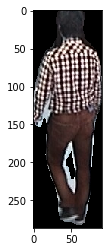

idx 69, tidx 0, cidx: 0, pc_dist: 0.063268
min_dist: 0 True 01 0.03277331590652466
min_dist: 1 True 02 0.022601962089538574
min_dist: 2 True 03 0.030518174171447754
min_dist: 3 True 04 0.030403554439544678
min_dist: 4 True 05 0.1310010552406311
min_dist: 5 True 06 0.052654385566711426
min_dist: 6 True 07 0.04437446594238281
min_id_name: 02
N: 1
idx 70 True


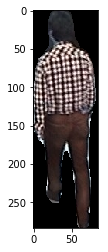

idx 70, tidx 0, cidx: 0, pc_dist: 0.059963
min_dist: 0 True 01 0.034354984760284424
min_dist: 1 True 02 0.02143031358718872
min_dist: 2 True 03 0.029722869396209717
min_dist: 3 True 04 0.029886364936828613
min_dist: 4 True 05 0.12715089321136475
min_dist: 5 True 06 0.051029205322265625
min_dist: 6 True 07 0.04462689161300659
min_id_name: 02
N: 1
idx 71 True


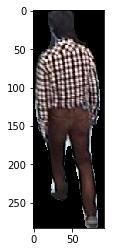

idx 71, tidx 0, cidx: 0, pc_dist: 0.077816
min_dist: 0 True 01 0.027088046073913574
min_dist: 1 True 02 0.011490941047668457
min_dist: 2 True 03 0.0208432674407959
min_dist: 3 True 04 0.02039867639541626
min_dist: 4 True 05 0.10383498668670654
min_dist: 5 True 06 0.038138747215270996
min_dist: 6 True 07 0.033605873584747314
min_id_name: 02
N: 1
idx 72 True


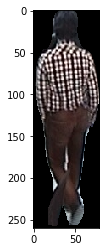

idx 72, tidx 0, cidx: 0, pc_dist: 0.061020
min_dist: 0 True 01 0.020533978939056396
min_dist: 1 True 02 0.010634958744049072
min_dist: 2 True 03 0.016278862953186035
min_dist: 3 True 04 0.016140878200531006
min_dist: 4 True 05 0.1026880145072937
min_dist: 5 True 06 0.03293710947036743
min_dist: 6 True 07 0.027713537216186523
min_id_name: 02
N: 3
idx 73 True


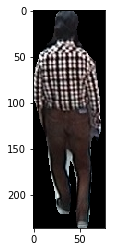

idx 73, tidx 0, cidx: 0, pc_dist: 0.058694
idx 73 True


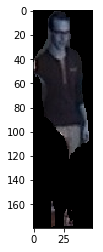

idx 73, tidx 0, cidx: 1, pc_dist: 0.242785
idx 73 True


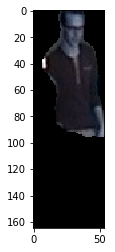

min_dist: 0 True 01 0.015739500522613525
min_dist: 1 True 02 0.014508366584777832
min_dist: 2 True 03 0.01463252305984497
min_dist: 3 True 04 0.01478666067123413
min_dist: 4 True 05 0.1036650538444519
min_dist: 5 True 06 0.030455827713012695
min_dist: 6 True 07 0.024366378784179688
min_id_name: 02
min_dist: 0 True 01 0.008639216423034668
min_dist: 1 True 02 0.01603078842163086
min_dist: 2 True 03 0.004157006740570068
min_dist: 3 True 04 0.004782497882843018
min_dist: 4 True 05 0.0478053092956543
min_dist: 5 True 06 0.0015482902526855469
min_dist: 6 True 07 0.0025954842567443848
min_id_name: 06
min_dist: 0 True 01 0.012505948543548584
min_dist: 1 True 02 0.022855818271636963
min_dist: 2 True 03 0.008333921432495117
min_dist: 3 True 04 0.008585691452026367
min_dist: 4 True 05 0.043018639087677
min_dist: 5 True 06 0.0018673539161682129
min_dist: 6 True 07 0.0038517117500305176
min_id_name: 06
N: 2
idx 74 True


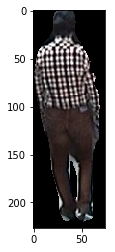

idx 74, tidx 0, cidx: 0, pc_dist: 0.038019
idx 74, tidx 1, cidx: 0, pc_dist: 0.217319
idx 74, tidx 2, cidx: 0, pc_dist: 0.260069
idx 74 True


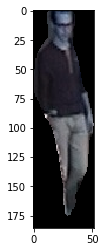

idx 74, tidx 0, cidx: 1, pc_dist: 0.090023
idx 74, tidx 1, cidx: 1, pc_dist: 0.197122
idx 74, tidx 2, cidx: 1, pc_dist: 0.237929
min_dist: 0 True 01 0.013406693935394287
min_dist: 1 True 02 0.01059800386428833
min_dist: 2 True 03 0.0112379789352417
min_dist: 3 True 04 0.011091768741607666
min_dist: 4 True 05 0.09474802017211914
min_dist: 5 True 06 0.025711238384246826
min_dist: 6 True 07 0.020581305027008057
min_id_name: 02
min_dist: 0 True 01 0.010660290718078613
min_dist: 1 True 02 0.01038283109664917
min_dist: 2 True 03 0.010323286056518555
min_dist: 3 True 04 0.008191704750061035
min_dist: 4 True 05 0.08612334728240967
min_dist: 5 True 06 0.022093892097473145
min_dist: 6 True 07 0.017202436923980713
min_id_name: 04
min_dist: 0 True 01 0.012505948543548584
min_dist: 1 True 02 0.022855818271636963
min_dist: 2 True 03 0.008333921432495117
min_dist: 3 True 04 0.008585691452026367
min_dist: 4 True 05 0.043018639087677
min_dist: 5 True 06 0.0018673539161682129
min_dist: 6 True 07 0.00385

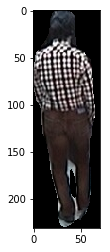

idx 75, tidx 0, cidx: 0, pc_dist: 0.042239
idx 75, tidx 1, cidx: 0, pc_dist: 0.091486
idx 75, tidx 2, cidx: 0, pc_dist: 0.290762
idx 75 True


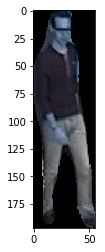

idx 75, tidx 0, cidx: 1, pc_dist: 0.101841
idx 75, tidx 1, cidx: 1, pc_dist: 0.108352
idx 75, tidx 2, cidx: 1, pc_dist: 0.304508
min_dist: 0 True 01 0.017217516899108887
min_dist: 1 True 02 0.015669167041778564
min_dist: 2 True 03 0.016329050064086914
min_dist: 3 True 04 0.016017496585845947
min_dist: 4 True 05 0.10644572973251343
min_dist: 5 True 06 0.033125877380371094
min_dist: 6 True 07 0.026547729969024658
min_id_name: 02
min_dist: 0 True 01 0.01778256893157959
min_dist: 1 True 02 0.023023486137390137
min_dist: 2 True 03 0.020343005657196045
min_dist: 3 True 04 0.019749999046325684
min_dist: 4 True 05 0.11363685131072998
min_dist: 5 True 06 0.03698009252548218
min_dist: 6 True 07 0.029717326164245605
min_id_name: 01
min_dist: 0 True 01 0.012505948543548584
min_dist: 1 True 02 0.022855818271636963
min_dist: 2 True 03 0.008333921432495117
min_dist: 3 True 04 0.008585691452026367
min_dist: 4 True 05 0.043018639087677
min_dist: 5 True 06 0.0018673539161682129
min_dist: 6 True 07 0.003

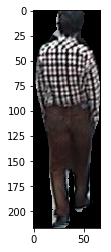

idx 76, tidx 0, cidx: 0, pc_dist: 0.103793
idx 76, tidx 1, cidx: 0, pc_dist: 0.151232
idx 76, tidx 2, cidx: 0, pc_dist: 0.294473
idx 76 True


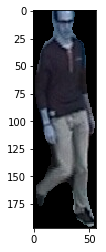

idx 76, tidx 0, cidx: 1, pc_dist: 0.106656
idx 76, tidx 1, cidx: 1, pc_dist: 0.103054
idx 76, tidx 2, cidx: 1, pc_dist: 0.294867
min_dist: 0 True 01 0.023026585578918457
min_dist: 1 True 02 0.009101510047912598
min_dist: 2 True 03 0.018788516521453857
min_dist: 3 True 04 0.01755821704864502
min_dist: 4 True 05 0.10025453567504883
min_dist: 5 True 06 0.03553652763366699
min_dist: 6 True 07 0.030855238437652588
min_id_name: 02
min_dist: 0 True 01 0.02022629976272583
min_dist: 1 True 02 0.016116023063659668
min_dist: 2 True 03 0.020298659801483154
min_dist: 3 True 04 0.01744943857192993
min_dist: 4 True 05 0.10133928060531616
min_dist: 5 True 06 0.03662514686584473
min_dist: 6 True 07 0.03092902898788452
min_id_name: 02
N: 2
idx 77 True


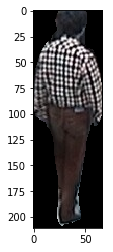

idx 77, tidx 0, cidx: 0, pc_dist: 0.052607
idx 77, tidx 1, cidx: 0, pc_dist: 0.110533
idx 77 True


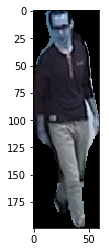

idx 77, tidx 1, cidx: 1, pc_dist: 0.114044
min_dist: 0 True 01 0.018466413021087646
min_dist: 1 True 02 0.01089489459991455
min_dist: 2 True 03 0.015994369983673096
min_dist: 3 True 04 0.015518426895141602
min_dist: 4 True 05 0.10132497549057007
min_dist: 5 True 06 0.03282487392425537
min_dist: 6 True 07 0.027066171169281006
min_id_name: 02
min_dist: 0 True 01 0.018375694751739502
min_dist: 1 True 02 0.0262337327003479
min_dist: 2 True 03 0.02318209409713745
min_dist: 3 True 04 0.0212671160697937
min_dist: 4 True 05 0.11477929353713989
min_dist: 5 True 06 0.040018558502197266
min_dist: 6 True 07 0.032417356967926025
min_id_name: 01
N: 2
idx 78 True


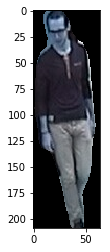

idx 78, tidx 1, cidx: 0, pc_dist: 0.066562
idx 78 True


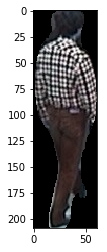

idx 78, tidx 0, cidx: 1, pc_dist: 0.032245
min_dist: 0 True 01 0.02281057834625244
min_dist: 1 True 02 0.012496531009674072
min_dist: 2 True 03 0.01992422342300415
min_dist: 3 True 04 0.018857717514038086
min_dist: 4 True 05 0.1068805456161499
min_dist: 5 True 06 0.038038790225982666
min_dist: 6 True 07 0.03206300735473633
min_id_name: 02
min_dist: 0 True 01 0.01913851499557495
min_dist: 1 True 02 0.029004812240600586
min_dist: 2 True 03 0.024670839309692383
min_dist: 3 True 04 0.02359873056411743
min_dist: 4 True 05 0.11995309591293335
min_dist: 5 True 06 0.04265648126602173
min_dist: 6 True 07 0.034084439277648926
min_id_name: 01
N: 2
idx 79 True


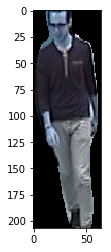

idx 79, tidx 1, cidx: 0, pc_dist: 0.087031
idx 79 True


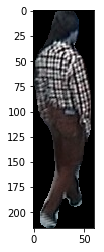

idx 79, tidx 0, cidx: 1, pc_dist: 0.087605
idx 79, tidx 1, cidx: 1, pc_dist: 0.120506
min_dist: 0 True 01 0.02208000421524048
min_dist: 1 True 02 0.019211888313293457
min_dist: 2 True 03 0.022084355354309082
min_dist: 3 True 04 0.02184218168258667
min_dist: 4 True 05 0.1175835132598877
min_dist: 5 True 06 0.040418148040771484
min_dist: 6 True 07 0.03348898887634277
min_id_name: 02
min_dist: 0 True 01 0.03227996826171875
min_dist: 1 True 02 0.0398288369178772
min_dist: 2 True 03 0.03742718696594238
min_dist: 3 True 04 0.03707486391067505
min_dist: 4 True 05 0.14192765951156616
min_dist: 5 True 06 0.05934041738510132
min_dist: 6 True 07 0.049857497215270996
min_id_name: 01

idx: 80
N: 2
idx 80, tidx 0, cidx: 0, pc_dist: 0.123558
idx 80, tidx 1, cidx: 0, pc_dist: 0.083879
idx 80, tidx 0, cidx: 1, pc_dist: 0.059369
idx 80, tidx 1, cidx: 1, pc_dist: 0.143513
min_dist: 0 True 01 0.018182754516601562
min_dist: 1 True 02 0.01658618450164795
min_dist: 2 True 03 0.018366456031799316
min_dist: 3 

In [104]:
%matplotlib inline  

import time

## for images.
d_path ="/datasets/data/2014/heidi_test/conv2B_test6/*.jpg"
#"/home/heidi/Dataset/video/omni_1B/omni1B_test6/*.jpg"
filenames = glob.glob(d_path)
filenames.sort(reverse=True)

frame = cv2.imread('/datasets/data/2014/heidi_test/conv2B_test6/2015-11-13T12-38-45.514Z.jpg')
fh,fw,fch = frame.shape
print('frame.shape: ',fh,fw)

size = fh,fw

isRecording = True
                  
filenames = filenames#[100:]
print(len(filenames))

dth = 0.5
# tracking_infos_bool = False
# tracking_infos = []
current_cam_n=0

## save frame path
save_result_dir="/datasets/data/2014/heidi_test"#"/heidi_net/result"


output_path = join(save_result_dir,'output_conv2B_test6_m3')
__create_dir__(output_path)

mr_output_path = join(save_result_dir,'mr_output_conv2B_test6_m3_2')
__create_dir__(mr_output_path)

mr_output_path2 = join(save_result_dir,'mr_output2')
__create_dir__(mr_output_path2)

#alll_cam_n = 1
# new_list = [(47,3),(73,2),(96,3),(124,2),(156,2),(178,5),(0,-1)]

#main_id_infos = ori_main_id_infos.copy()

#previous_infos = [[] for _ in range(alll_cam_n)]


# pre_frame_idx=0
alll_cam_n = 1
tracking_infos =  [[] for _ in range(alll_cam_n)]

new_person_idx = 0
font_size = 1

#filenames=filenames[150:]
#try:
if True:
    idx = -1
    while (filenames):
        if isRecording:
            idx+=1
            time.sleep(0.1)
            if idx>350:
                break
            
            if idx%20 ==0:
                print('\nidx:',idx)
            #time.sleep(0.01)

            ## image read
            img_path=filenames.pop()
            img = cv2.imread(img_path)
            
            
            #"""
            img,  tracking_infos, new_person_idx = tracking_heidinet(img, alll_cam_n, 
                                                                     tracking_infos, new_person_idx, 
                                                                     font_size=1,
                                                                     miss_frame_num=3,
                                                                     mr_output_path=mr_output_path)
            
            #"""   
            
            # here tap starttracking_cam_n
            ## *** re rank***       

            #cv2.imshow('draw_img',img)
            cv2.imwrite(join(output_path,str(idx)+'.jpg'),img)

        k = cv2.waitKey(30) & 0xff
        if k == 27: #esc key
            breakcap = cv2.VideoCapture(d_path)
        if k == ord('p'):#Pause 
            isRecording=Falseis_person
        if k == ord('c'):#Continue 
            isRecording=True 
        if k == ord('q'):#Continue 
            isRecording=False
            breakget_iou

    cv2.destroyAllWindows()
    print('done')
# except Exception as e:
#     cv2.destroyAllWindows()
#     PrintException()



---

In [90]:
from scipy import spatial

In [46]:
def get_temp_f(p_1):
    img1 = cv2.imread(p_1)
    pre_id_img1 = __get_heiditest_cv_data__(img1)
    id_feature1 = heidi_resnet_model.predict(pre_id_img1)
    return id_feature1

In [102]:
p_1=  '/datasets/data/2014/heidi_test/mr_output_conv2B_test6_m3_2/85_0_2_.jpg'
p_2=  '/datasets/data/2014/heidi_test/id_data/p02_00.png'
p_3=  '/datasets/data/2014/heidi_test/id_data/p04_00.png'

f1=get_temp_f(p_1)
f2=get_temp_f(p_2)
f3=get_temp_f(p_3)

In [103]:
pc_dist = np.linalg.norm(f1 - f2)
cos_dist = spatial.distance.cosine(f1, f2)
print(pc_dist, cos_dist)

pc_dist = np.linalg.norm(f1 - f3)
cos_dist = spatial.distance.cosine(f1, f3)
print(pc_dist, cos_dist)

0.1847094 0.017058730125427246
0.20417555 0.020843863487243652


In [54]:
frame_feature=f1
min_dist =999
min_dist_idx= -1
for ifidx, id_feature_info in enumerate(id_feature_list):
    id_name = id_feature_info[0]
    id_feature = id_feature_info[1]

    pc_dist = np.linalg.norm(id_feature - frame_feature)

    print('min_dist:',ifidx,id_name,pc_dist)

    min_dist = min(min_dist, pc_dist)


    if min_dist==pc_dist:
        min_dist_idx=ifidx
min_id_name = id_feature_list[min_dist_idx][0]
print('min_id_name:',min_id_name)



min_dist: 0 p01.png 0.49514547
min_dist: 1 p02.png 0.3299522
min_dist: 2 p03.png 0.44471294
min_dist: 3 p04.png 0.43176177
min_dist: 4 p05.png 0.5319114
min_dist: 5 p06.png 0.47425678
min_dist: 6 p07.png 0.47957706
min_id_name: p02.png
